<a href="https://colab.research.google.com/github/CesarAugusto88/dissertation/blob/main/Training_Unet_Landslides_Charter_Sao_Sebastiao_INPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="text-align:center">
Instituto Nacional de Pesquisas Espaciais, INPE <br>
Graduado em Computação Aplicada, CAP <br>

Autor: Cesar Augusto de Moraes Costa

Data: 22/11/2023

#1: Introdução: Notebook para treinamento da U-Net para o chamado Charter de São Sebastião
O modelo de Redes Neurais Convolucionais (CNN) de segmentação semântica U-Net, foi aplicadi usando a API Keras, para classificação pixel a pixel de fragmentos de imagens bitemporais contendo deslizamentos. Neste notebook para treinamento do modelo, foi usado um *dataset* do desastre do dia 19 de fevereiro de 20223, na região de São Sebastião, São Paulo, processados para o Chamado Charter, realizado por pesquisadores do INPE. O objetivo do projeto foi utilizar a arquitetura U-Net treinada para o domínio de desastre de deslizamentos de terra ocorrido em São Sebastão (dados balanceados), para classificar os dados do desastre de petrópolis - RJ, do dia 15 de fevereiro de 2022.

## 2: Configurações iniciais - Chamado Charter São Sebastião

### Carregar imagens contidas no drive


In [2]:
# Download arquivos
!gdown --folder 1eWf4pEHiQezcjqs1t3wjRa_MGUlk2XEO -q

In [3]:
from osgeo import gdal

p2022 = '/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20220117_201_143_L4_pansharpening_barra_do_sahy.tif'
img2022 = gdal.Open(p2022)
r2022= img2022.GetGeoTransform()
print(r2022)
p2023 = '/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20230301_201_143_L4_compose_pansharpening_barra_do_sahy.tif'
img2023 = gdal.Open(p2023)
r2023 = img2023.GetGeoTransform()
print(r2023)

(422462.0, 2.0, 0.0, 7377932.0, 0.0, -2.0)
(422462.0, 2.0, 0.0, 7377932.0, 0.0, -2.0)


In [4]:
!pip install -q rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 56.4 MB/s eta 0:00:00


In [5]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

rasterio.__version__

'1.3.9'

## 3: Concatenação de imagens pansharpening São Sebastião (T2/T1)

(8, 7499, 7193)
(7499, 7193, 4)


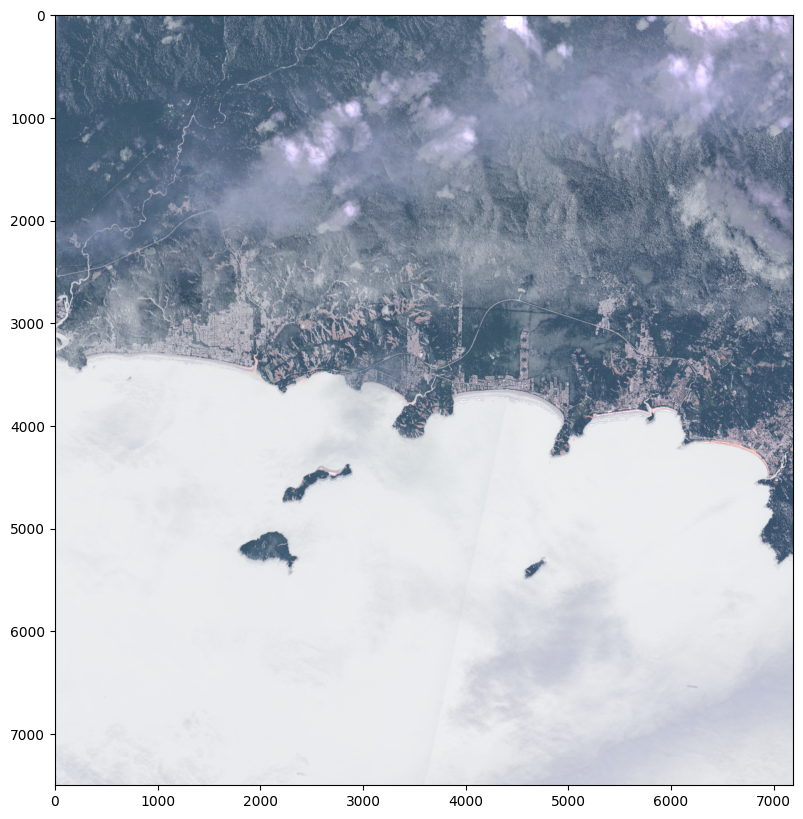

In [6]:
array_T1 = rasterio.open('/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20220117_201_143_L4_pansharpening_barra_do_sahy.tif').read()
array_T2 = rasterio.open('/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20230301_201_143_L4_compose_pansharpening_barra_do_sahy.tif').read()

merge = np.concatenate((array_T2,array_T1), axis=0)  # axis 0 profundidade, 1 hor, 2 vert
print(merge.shape)

# plt.figure(figsize=(15,10))
# plt.gray()
# plt.imshow(merge[0,:,:]);

# Stack RGB NIR
merge_ = np.stack([merge[2],merge[1],
                  merge[0],merge[3]], axis=2)
# merge_ = np.stack(merge, axis=2)
# merge_ = np.dstack(merge)

print(merge_.shape)

rgbnir_t2_t1 = merge_ / merge_.max()
plt.figure(figsize=(15, 10))
plt.imshow(rgbnir_t2_t1*3)

In [7]:
#save image concatenated T2 and T1, to create patches
merge.shape, merge_.shape

((8, 7499, 7193), (7499, 7193, 4))

(8, 1200, 1700)
(1200, 1700, 4)


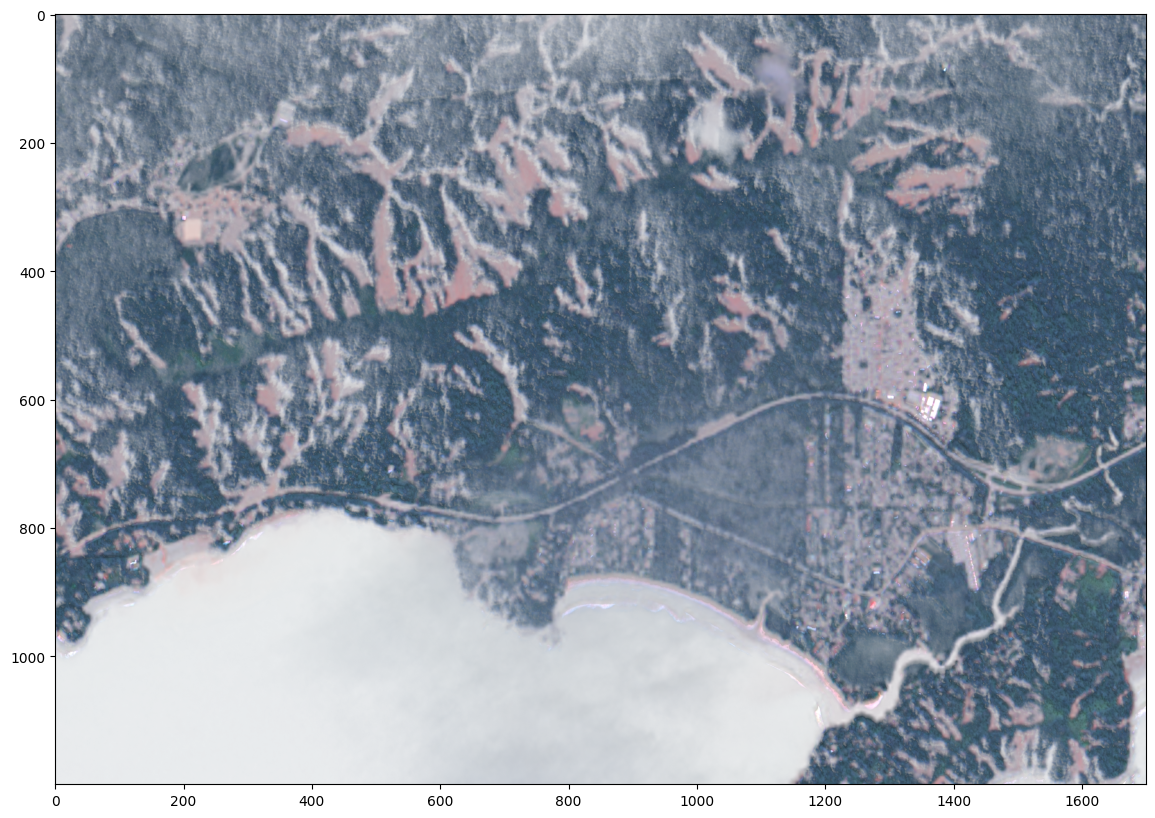

In [8]:
# merge_crop = merge[:,2700:3900,2200:3800] #229 deslizamentos e 221 não-deslizamentos

merge_crop = merge[:,2700:3900,2200:3900] #deslizamento: 232; não-deslizamentos: 236.

print(merge_crop.shape)
merge_ = np.stack([merge_crop[2],merge_crop[1],
                  merge_crop[0],merge_crop[3]], axis=2)
# merge_ = np.stack(merge, axis=2)
# merge_ = np.dstack(merge)

print(merge_.shape)

rgbnir_t2_t1 = merge_ / merge_.max()
plt.figure(figsize=(15, 10))
plt.imshow(rgbnir_t2_t1*3)

Gerar mapa

In [9]:
##Importar biblioteca
import rasterio
from rasterio.plot import show

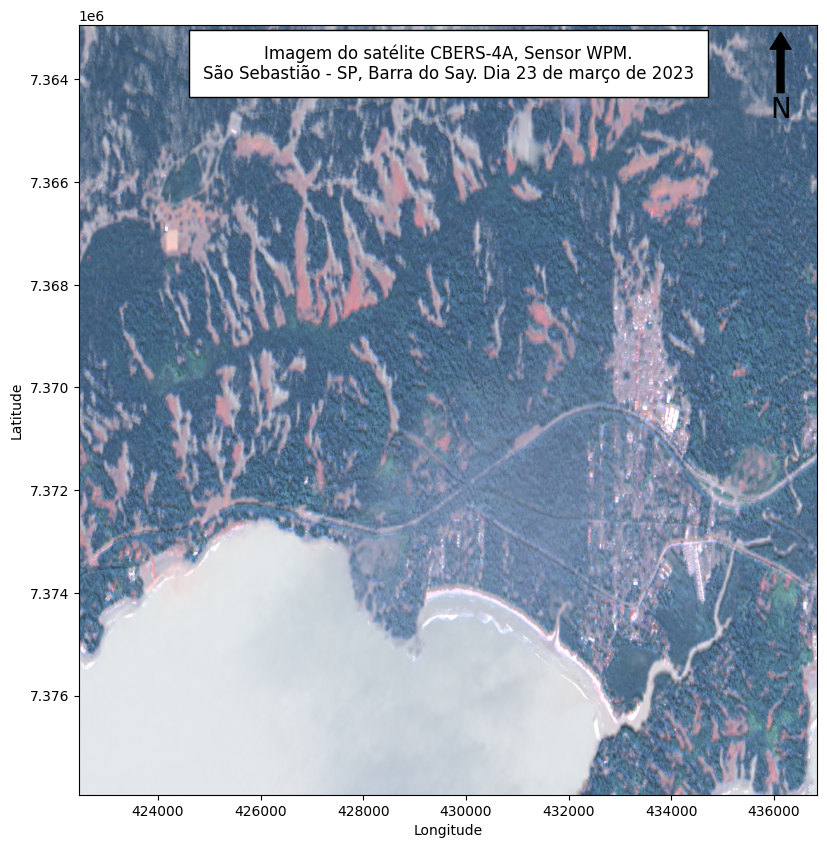

In [10]:
# Carregue a imagem raster com rasterio
path_to_raster = "/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20230301_201_143_L4_compose_pansharpening_barra_do_sahy.tif"
dataset = rasterio.open(path_to_raster)

# Ler os dados e a transformação do raster
data = dataset.read(1)  # Assumindo que é uma banda de dados
transform = dataset.transform

# Obter coordenadas de latitude e longitude para as bordas do raster
min_x, min_y = transform * (0, 0)
max_x, max_y = transform * (data.shape[1], data.shape[0])

# Plotar a imagem raster usando matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

# Plotar o raster com imshow e integração com o plt
img = ax.imshow(rgbnir_t2_t1 * 4, cmap="terrain", extent=[min_x, max_x, min_y, max_y])
# plt.colorbar(img, label="Escala")

# Personalizar rótulos e título do gráfico
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.title("Desastre em São Sebastião - SP")

# Inserir grids
# ax.grid(color='0.95', linestyle='dashed', linewidth=0.5, alpha=0.5)

# # Plotar box de informações
ax.text(0.5, 0.95,'Imagem do satélite CBERS-4A, Sensor WPM.\nSão Sebastião - SP, Barra do Say. Dia 23 de março de 2023',
        fontsize=12, transform=ax.transAxes, ha='center', va='center', bbox={'facecolor': 'white', 'pad': 10})

# Adicionar a orientação do norte
x, y, arrow_length = 0.95, 0.99, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Mostrar o gráfico na tela
plt.show()

In [11]:
dataset = gdal.Open("/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20230301_201_143_L4_compose_pansharpening_barra_do_sahy.tif", gdal.GA_ReadOnly)
GT = dataset.GetGeoTransform()
print(GT)

(422462.0, 2.0, 0.0, 7377932.0, 0.0, -2.0)


### 3.1: Transf Affine

In [12]:
from affine import Affine
transf = (422462.0, 2.0, 0.0, 7377932.0, 0.0, -2.0)
af_transf = Affine.from_gdal(*transf)
print(af_transf)

| 2.00, 0.00, 422462.00|
| 0.00,-2.00, 7377932.00|
| 0.00, 0.00, 1.00|


In [13]:
dataset = rasterio.open('/content/Deslizamentos_Chamado_Charter_925/CBERS_4A_WPM_20220117_201_143_L4_pansharpening_barra_do_sahy.tif')
print(dataset.profile)
dst_crs = 'EPSG:32723'

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 7193, 'height': 7499, 'count': 4, 'crs': CRS.from_epsg(32723), 'transform': Affine(2.0, 0.0, 422462.0,
       0.0, -2.0, 7377932.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


In [14]:
# SAVE
with rasterio.open(
    'raster_out_concatenate_charter_t2_t1.tif',
    'w',
    driver='GTiff',
    height=merge_crop.shape[1],
    width=merge_crop.shape[2],
    count=8,
    dtype=np.float32,
    crs=dst_crs,
    transform=af_transf,
) as dest_file:
    dest_file.write(merge_crop)
dest_file.close()

(1200, 1700, 4)


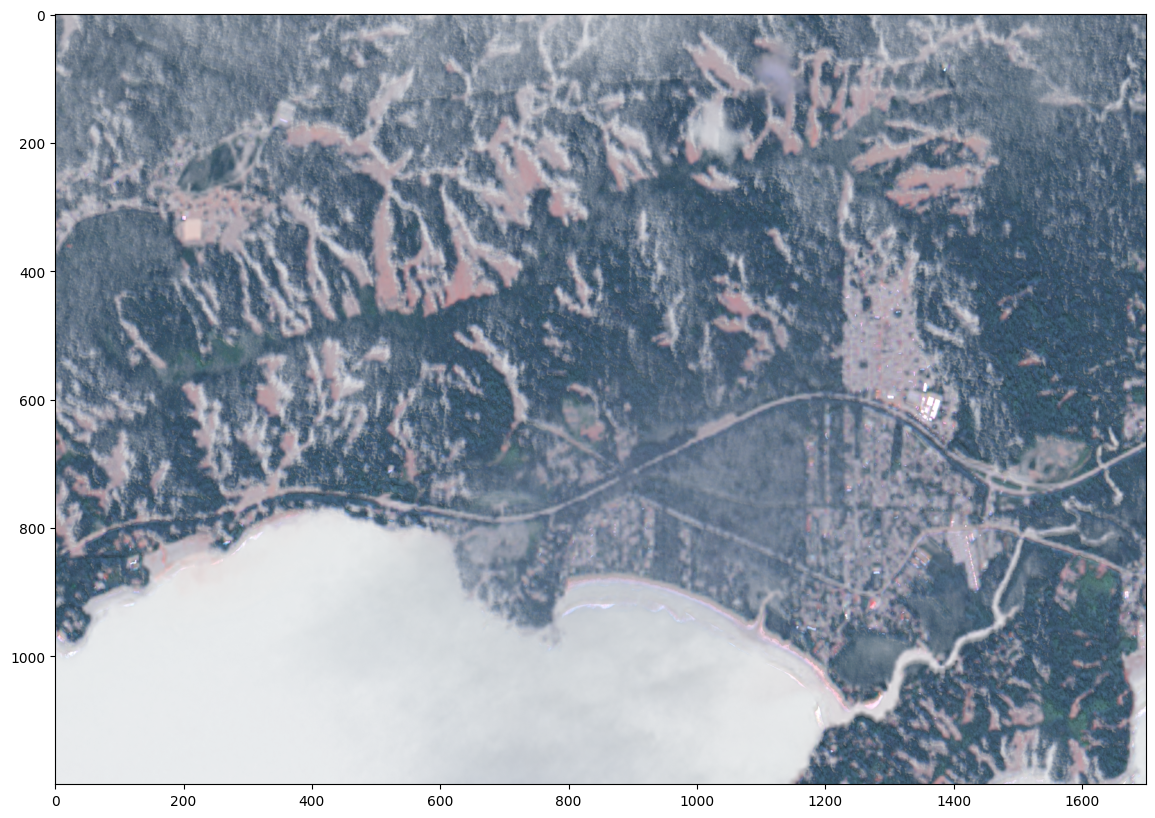

In [15]:
img_concat_array = rasterio.open('raster_out_concatenate_charter_t2_t1.tif').read()
# Stack RGB NIR - 8 channels
img_concat_array = np.stack([img_concat_array[2],img_concat_array[1],
                  img_concat_array[0],img_concat_array[3]], axis=2)

print(img_concat_array.shape)

concat_t2_t1 = img_concat_array / img_concat_array.max()
plt.figure(figsize=(15, 10))
plt.imshow(concat_t2_t1*3)

In [16]:
dataset_concatenate = gdal.Open("raster_out_concatenate_charter_t2_t1.tif", gdal.GA_ReadOnly)
GT_concatenate = dataset_concatenate.GetGeoTransform()
print(GT_concatenate)

(422462.0, 2.0, 0.0, 7377932.0, 0.0, -2.0)


##3.2 : Após criar coluna de deslizamento e não-deslizamento na tabela de atributos, foi feito a conversão de shapefile para raster, criar patches de rótulos 64 x 64.

In [17]:
# Classes criadas pelo módulo para converter shapefile em raster
# Usar classes feitas pelo QGIS
# !gdown --id 17FHsd7KluFey3yyCyQV90_SC369fjqHv

(1, 7499, 7193)

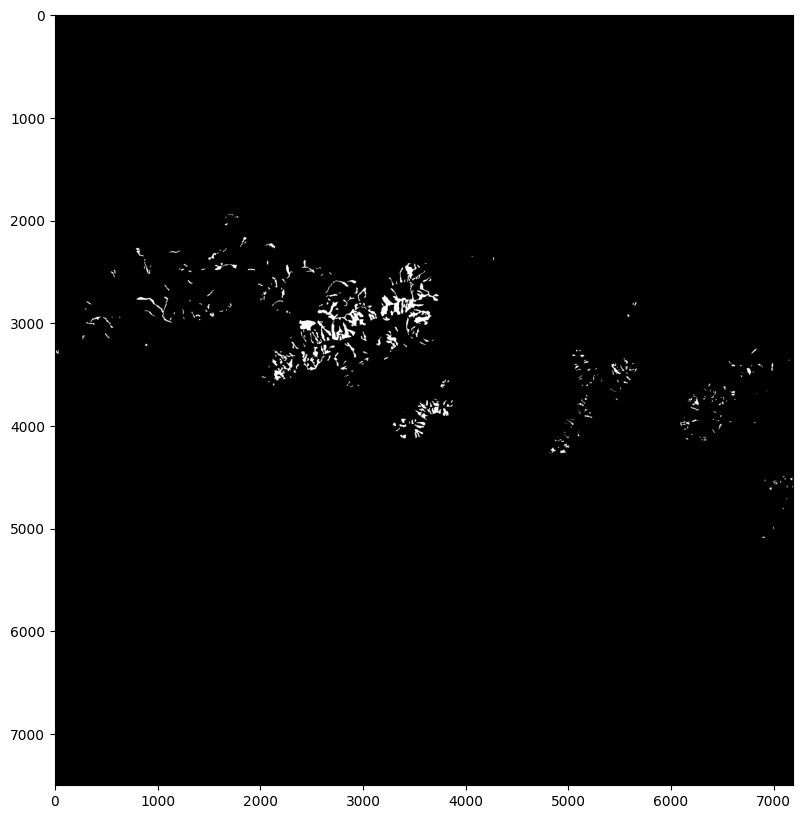

In [18]:
img = rasterio.open('/content/Deslizamentos_Chamado_Charter_925/classes_qis_barra_do_sahy.tif').read()
plt.figure(figsize=(10, 10))
plt.imshow(img[0,:,:], cmap='gray');
img.shape

In [19]:
img_crop = img[:,2700:3900,2200:3900]
img_crop.shape

(1, 1200, 1700)

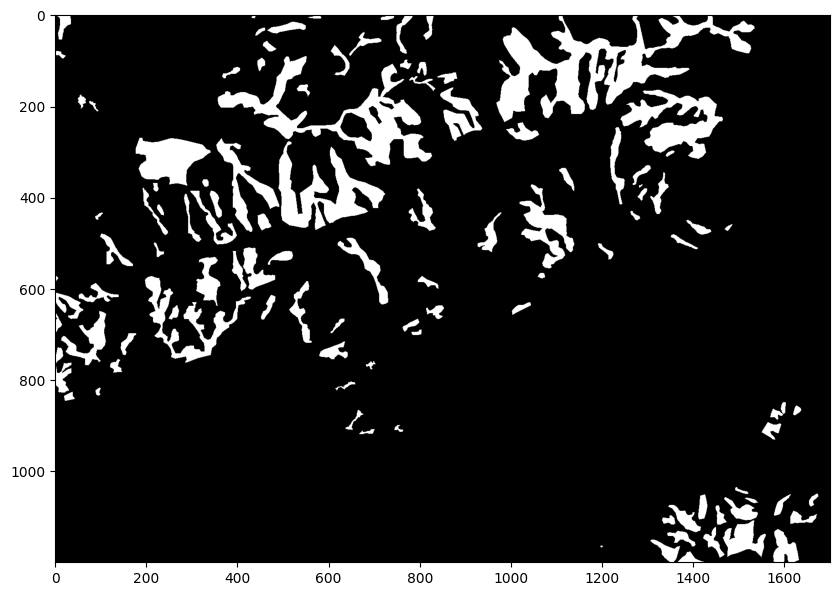

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(img_crop[0,:,:], cmap='gray');

In [21]:
# SAVE
with rasterio.open(
    'deslizamentos_preliminar_classnumber_CBERS4A_crop.tif',
    'w',
    driver='GTiff',
    height=img_crop.shape[1],
    width=img_crop.shape[2],
    count=1,
    dtype=np.float32,
    crs=dst_crs,
    transform=af_transf,
) as dest_file:
    dest_file.write(img_crop)
dest_file.close()

## 3.3: Criando patches 64 x 64 - systematic [3]

In [22]:
from osgeo import gdal
def systematic(tif_path, pixelX=None, pixelY=None, tamX=None,
                    tamY=None, sobras=False):
    """
    Função para criação de patches conforme parâmetros escolhidos pelo usuário.

    patch_generator(tif_path, pixelX=None, pixelY=None, tamX=None,
                    tamY=None, sobras = False)


    tif_path: Deve ser inserida uma string com o
    diretório onde a imagem raster está inserida.
    ex: '/content/crop_rapideye.tif'


    pixelX: Deve ser inserido um valor inteiro com
    a dimensão desejada para o eixo X do patche.
    (Dimensão X do Patche em pixels)
    ex: 300

    pixelY: Deve ser inserido um valor inteiro com
    a dimensão desejada para o eixo Y do patche.
    (Dimensão Y do Patche em pixels)
    ex: 300

    tamX: Deve ser inserido um valor inteiro, em metros, da
    dimensão desejada para o eixo X do patche.
    (Dimensão X do Patche em metros)
    ex: 1500

    tamY: Deve ser inserido um valor inteiro, em metros, da
    dimensão desejada para o eixo Y do patche
    (Dimensão Y do Patche em metros)
    ex: 1500

    sobras: Quando True irá gerar recortes das bordas, caso estas
    apresentem dimensões inferiores às inseridas pelo usuário


    Exemplo de aplicação:
    Por exemplo, inserindo os seguintes parâmetros...

    patch_generator('/content/crop_rapideye.tif', pixelX=300, pixelY=300)

    Serão criados patches de 300x300 pixels do raster
    crop_rapideye.tif
    """

    raster = gdal.Open(tif_path)

    # Coletando os dados do raster
    gt = raster.GetGeoTransform()
    name = raster.GetDescription()
    name = name.split('.')[-2]

    # Separando os valores da lista gt
    # Coleta da coordenada x do canto superior esquerdo
    img_xmin = gt[0]
    # Coleta da coordenada y do canto superior esquerdo
    img_ymax = gt[3]
    # Coleta da resolução da imagem
    res = gt[1]

    # Verificandoo tamanho da imagem nos eixos x e y.
    # n_pixelsx é o numero de pixels na dimensão x
    # n_pixelsy é o numero de pixels na dimensão y
    n_pixelsx = raster.RasterXSize
    n_pixelsy = raster.RasterYSize

    # img_xlen é tamanho da imagem em metros na dimensão x
    # img_ylen é tamanho da imagem em metros na dimensão y
    img_xlen = res * n_pixelsx
    img_ylen = res * n_pixelsy


    # Delimitando o tamanho do patch

    # Caso o usuário insera o valor das dimensões do patch em pixels
    if pixelX != None and pixelY != None:
        # tamanho do patch em metros
        patch_xlen = pixelX * res
        patch_ylen = pixelY * res
        print(f'Tamanho do patch: {patch_xlen}m x {patch_ylen}m')

    # Caso o usuário insira o valor das dimensões do patch em metros
    elif  tamX != None and tamY != None:
        patch_xlen = tamX
        patch_ylen = tamY

    # Verificação do número de patches por eixo (dimensão total da imagem no eixo x // dimensão do patch em metros no eixo x)
    xdiv = img_xlen//patch_xlen
    # Verificação do número de patches por eixo (dimensão total da imagem no eixo y // dimensão do patch em metros no eixo y)
    ydiv = img_ylen//patch_ylen

    # Verificação do número total de patches
    total_patches= xdiv*ydiv
    print(f'Número total de patches ({pixelX}m x{pixelY}m) criados: {total_patches}')

    # Testando se o tamanho da imagem é proporcional ao tamanho do patch nas duas dimensões
    # Verificando se o tamanho do patch inserido pelo usuário é múltiplo da dimensão da imagem tif

    if img_xlen % patch_xlen != 0 or img_ylen % patch_ylen !=0:
        print(f'O tamanho da imagem não é múltiplo do tamanho do patch.\n')

       # Se o valor na dimensão x ou y não for divisível pela dimensão total da imagem, será aumentado
       # um valor no número de sobras
        if sobras:
            if img_xlen % patch_xlen != 0:
                xdiv += 1
            elif img_ylen % patch_ylen !=0:
                ydiv += 1
                t_patches= xdiv*ydiv
            print(f'Número total de patches a serem criados (+ sobras): {total_patches} patches + {t_patches - total_patches} sobras')

    # img_xmin = coord_x canto superior esquerdo; img_ymax = coord_y canto superior esquerdo;

    # Criação de uma lista com as coordenadas em x, através de uma list comprehension
    # com step de 0 até o número total de patches no eixo x(xdiv)
    xsteps = [img_xmin + patch_xlen*i for i in range(int(xdiv)+1)]

    # Criação de uma lista com as coordenadas em y, através de uma list comprehension
    # com step de 0 até o número total de patches no eixo y(xdiv)
    ysteps = [img_ymax - patch_ylen*i for i in range(int(ydiv)+1)]

    # Pergunta para o usuário, verificando se ele realmente quer fazer o número de patches
    # Esse passo é para evitar a criação de números demasiados de patches devido erro de digitação
    resp = 'S'  # input(f'Dejesa criar {total_patches} patches? (S/N)')

    # Se a respota for Sim (S), os patches serão criados
    if resp.upper() == 'S':
        # id = número inicial do nome atribuído a cada um dos patches, começando pelo 1
        id = 1
        # Criação de dois for aninhado para a definição das coordenadas de recorte
        for i in range(int(xdiv)):
            for j in range(int(ydiv)):
                # Coordenadas x (max/min) para o recorte, extraídas da lista de coordenadas criadas anteriormente (xsteps)
                xmin = xsteps[i]
                xmax = xsteps[i+1]
                # Coordenadas y (max/min) para o recorte, extraídas da lista de coordenadas criadas anteriormente (ysteps)
                ymax = ysteps[j]
                ymin = ysteps[j+1]

                gdal.Warp(name + '_' + 'p' + str(id) +'.tif', raster, outputBounds = (xmin, ymin, xmax, ymax), dstNodata = -9999)
                id += 1
        print(f'>> {total_patches} patches criados!')

    # Caso a resposta seja não (n), o programa não irá criar os patches
    elif resp.upper() == 'N':
        print('Programa finalizado, você optou por não criar nenhum patche.')
        print('-' * 100)

In [23]:
systematic('/content/raster_out_concatenate_charter_t2_t1.tif', pixelX=64, pixelY=64, sobras=False)

Tamanho do patch: 128.0m x 128.0m
Número total de patches (64m x64m) criados: 468.0
O tamanho da imagem não é múltiplo do tamanho do patch.

>> 468.0 patches criados!


In [24]:
# CRIA DIRETÓRIO E MOVE PATCHES PARA LÁ
!mkdir patches_charter
!mkdir patches_charter/cenas
!mv /content/raster_out_concatenate_charter_t2_t1_p*.tif /content/patches_charter/cenas

In [25]:
systematic('/content/deslizamentos_preliminar_classnumber_CBERS4A_crop.tif', pixelX=64, pixelY=64, sobras=False)

Tamanho do patch: 128.0m x 128.0m
Número total de patches (64m x64m) criados: 468.0
O tamanho da imagem não é múltiplo do tamanho do patch.

>> 468.0 patches criados!


In [26]:
# CRIA DIRETÓRIO E MOVE PATCHES PARA LÁ
!mkdir patches_charter/classes
!mv /content/deslizamentos_preliminar_classnumber_CBERS4A_crop_p*.tif /content/patches_charter/classes

## 3.4: Leitura e visualização dos dados

### 3.4.1: Bibliotecas necessárias
<hr style="border:1px solid #7D26CD">

In [27]:
import os
import glob
# Dados
import imgaug as ia
import imgaug.augmenters as iaa
import random
import PIL
from PIL import Image
from PIL import ImageOps

# Leitura das imagens
from skimage import io

import numpy as np
import time

import pandas as pd
from tensorflow.keras.preprocessing import image

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

# Gráficos
import matplotlib.pyplot as plt
import random
from imageio import mimread

tf.__version__

'2.14.0'

In [28]:
seed = 42
np.random.seed = seed
random.seed = seed
tf.random.set_seed(42)

In [29]:
cbers_ = ['/content/patches_charter/cenas',
          '/content/patches_charter/classes']

In [30]:
# Função para leitura dos files
def read_image(image_path, mask=False):
    # Recebe os caminhos dos files
    img = io.imread(image_path)

    # Se for label a variável img receberá ela mesma
    if mask:
        # A imagem recebe apenas imagem
        img = img
    # Caso contrário,
    else:
        # se for patch o valores dos pixels é divido por 255
        img = img/255
    # A função retorna a imagem
    return img

In [31]:
# Organização da lista de rasters
# Lista: armazenará os paths de cada patch
org_path_pacth1 = []

# Loop: Acessa o diretório [0] para ler o paths
for raster in glob.iglob(cbers_[0]+'/*.tif'):
    # Armazena o paths na lista
    org_path_pacth1.append(raster)
# Ordena os strings dos paths
org_path_pacth1.sort()

# Organização da lista de labels
#Lista: armazenará os paths de cada patch
org_path_label1 = []
# Loop: Acessa o diretório [1] para ler o paths
for raster in glob.iglob(cbers_[1]+'/*.tif'):
    # Armazena o paths na lista
    org_path_label1.append(raster)
# Ordena os strings dos paths
org_path_label1.sort()

In [32]:
# Leitura e armazenamentos dos raster
# Lista: Armazenará as imagens
patche = []
# Loop: acessa cada path
for i in org_path_pacth1:
    # Leitura: chama a função de leitura
    imagem = read_image(i)
    # Armazena patches na lista
    patche.append(imagem)


In [33]:
# Leitura e armazenamentos dos labels
# Lista: Armazenará as imagens
label = []
# Loop: acessa cada path
for i in org_path_label1:
    # Leitura: chama a função de leitura
    mask = read_image(i, mask=True)

    new_mask = np.where(mask > 0, mask, 0)

    # Armazena labels na lista
    label.append(new_mask)

## Data augmentation e divisão de dados

In [34]:
# Função para aplicar aumento de dados nos patches de cenas e classes
def data_augmentation(patche_cena, patche_classe, num_augmentations):
    augmented_cenas = []
    augmented_classes = []

    for i in range(len(patche_cena)):
        # Replicar a amostra original tantas vezes quantas forem as augmentações desejadas
        for _ in range(num_augmentations):
            cena = patche_cena[i]
            classe = patche_classe[i]

            # Aplicar as transformações de aumento de dados aqui
            # Exemplo: rotação aleatória no intervalo de -50 a 30 graus
            angle = np.random.randint(-50, 30)
            augmented_cena = np.rot90(cena, k=angle // 90, axes=(0, 1))
            augmented_classe = np.rot90(classe, k=angle // 90, axes=(0, 1))

            # Exemplo: espelhamento horizontal aleatório
            if np.random.rand() < 0.5:
                augmented_cena = np.fliplr(augmented_cena)
                augmented_classe = np.fliplr(augmented_classe)

            # Exemplo: espelhamento vertical aleatório
            if np.random.rand() < 0.5:
                augmented_cena = np.flipud(augmented_cena)
                augmented_classe = np.flipud(augmented_classe)

            # Adicionar as amostras aumentadas às listas
            augmented_cenas.append(augmented_cena)
            augmented_classes.append(augmented_classe)

    # Transformar as listas em arrays numpy
    augmented_cenas = np.array(augmented_cenas)
    augmented_classes = np.array(augmented_classes)

    return augmented_cenas, augmented_classes

# Transforma dataset original em array e faz divisão para augmentation e teste
# 40% (188) para teste e 60% (280) para augmentation - aug em 4x + original = 1400
patche_cena_ = np.array(patche)
patche_classe_ = np.array(label)
len_patches = int(len(patche_classe_) * 0.6)
print(len_patches)
# teste separado
patche_cena_test = patche_cena_[len_patches:]
patche_classe_test = patche_classe_[len_patches:]
print('Ds para teste: ', patche_classe_test.shape)

patche_cena = patche_cena_[:len_patches]
patche_classe = patche_classe_[:len_patches]
print('Ds para augmentation: ', patche_classe.shape)

# Definir o número de augmentações desejadas para cada amostra (por exemplo, 4)
num_augmentations = 4

# Aplicar o aumento de dados
patche_cena_augmented, patche_classe_augmented = data_augmentation(patche_cena, patche_classe, num_augmentations)

# Verifique as dimensões dos arrays resultantes
print(patche_cena_augmented.shape)
print(patche_classe_augmented.shape)

# Juntar os dados aumentados com os dados originais
patche_cena_combined = np.concatenate((patche_cena, patche_cena_augmented), axis=0)
patche_classe_combined = np.concatenate((patche_classe, patche_classe_augmented), axis=0)

# Verifique as dimensões dos arrays resultantes
print(patche_cena_combined.shape)
print(patche_classe_combined.shape)

280
Ds para teste:  (188, 64, 64)
Ds para augmentation:  (280, 64, 64)
(1120, 64, 64, 8)
(1120, 64, 64)
(1400, 64, 64, 8)
(1400, 64, 64)


In [35]:
468*0.6, 280 * 5, 468-280  # 40% (188) para teste e 60% (280) para augmentation - aug em 4x + original = 1400

(280.8, 1400, 188)

In [36]:
# variáveis para contar deslizamentos e não deslizamentos
landslide = 0
no_landslide = 0

for i in range(len(patche_classe_)):

  classe = patche_classe_[i]
  # print(classe)
  # Verifica valor diferente de 0 na matriz para deslizamento
  if np.any(classe != 0):
    landslide += 1
  else:
    no_landslide += 1
#quantidade de deslizamentos e não deslizamentos
print(f'Dataset original \nNúmeros de deslizamento: {landslide}; Número de não-deslizamentos: {no_landslide}.')

Dataset original 
Números de deslizamento: 231; Número de não-deslizamentos: 237.


In [37]:
# variáveis para contar deslizamentos e não deslizamentos
landslide = 0
no_landslide = 0

for i in range(len(patche_classe_combined)):

  classe = patche_classe_combined[i]
  # print(classe)
  # Verifica valor diferente de 0 na matriz para deslizamento
  if np.any(classe != 0):
    landslide += 1
  else:
    no_landslide += 1
#quantidade de deslizamentos e não deslizamentos
print(f'Data augmentation \nNúmeros de deslizamento: {landslide}; Número de não-deslizamentos: {no_landslide}.')

Data augmentation 
Números de deslizamento: 785; Número de não-deslizamentos: 615.


In [38]:
# # Embaralha dados - Dificil classificação
# from sklearn.utils import shuffle
# def embaralha(x, y, seed=42):
#   x, y = shuffle(x, y, random_state=seed)
#   return x, y

# patche_cena, patche_classe = embaralha(patche_cena_combined, patche_classe_combined)

### 3.4.3: Visualizar patches das cenas e classes

In [39]:
patche_cena__ = patche_cena[:,:,:,0]

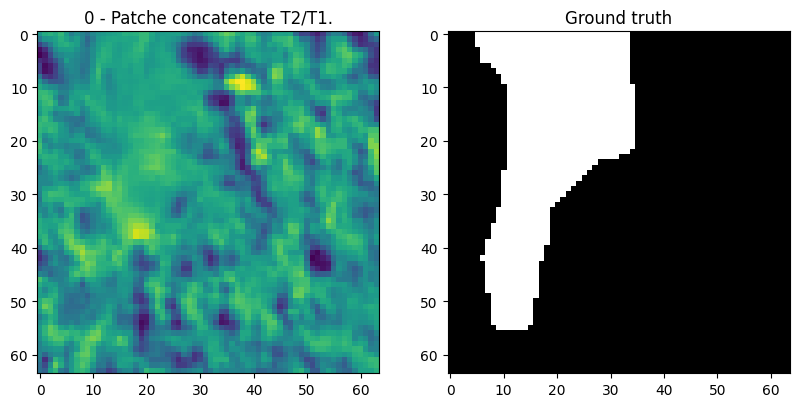

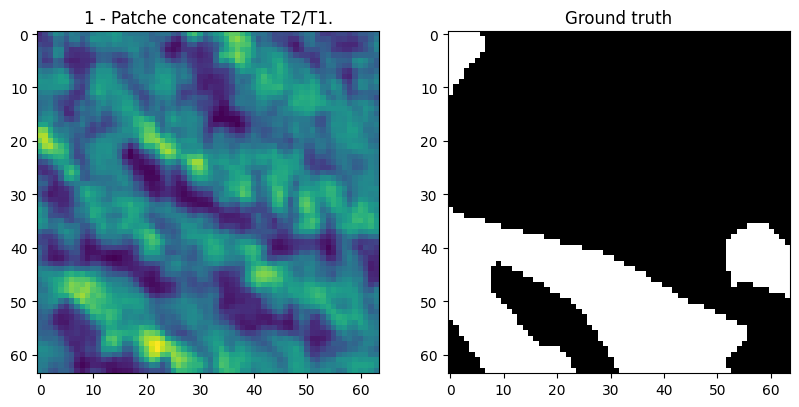

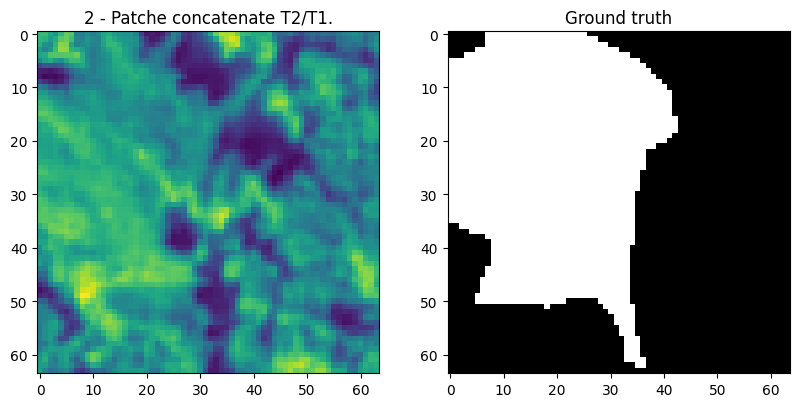

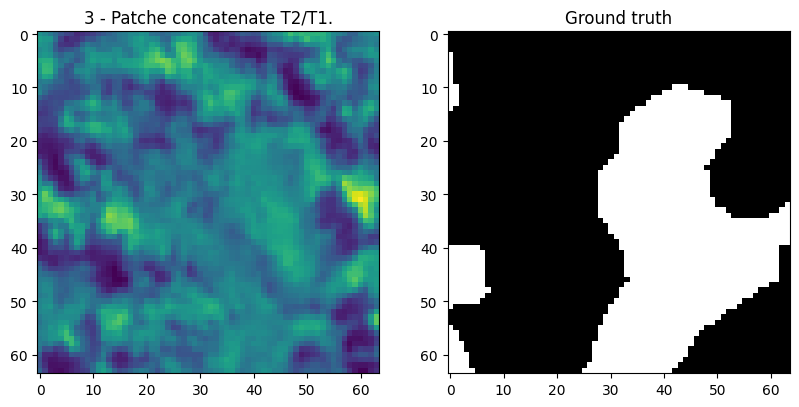

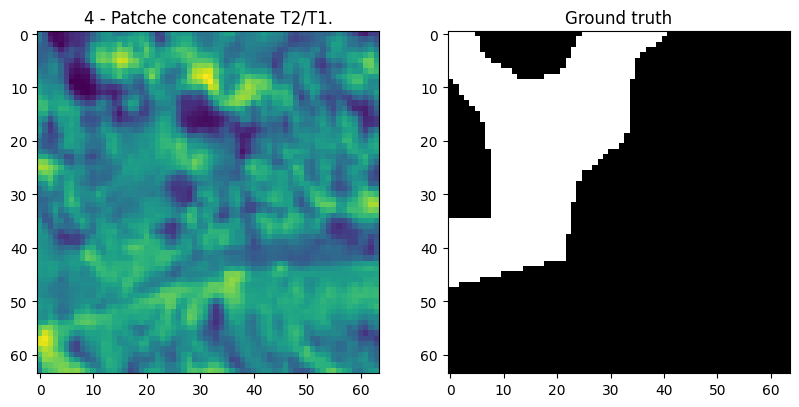

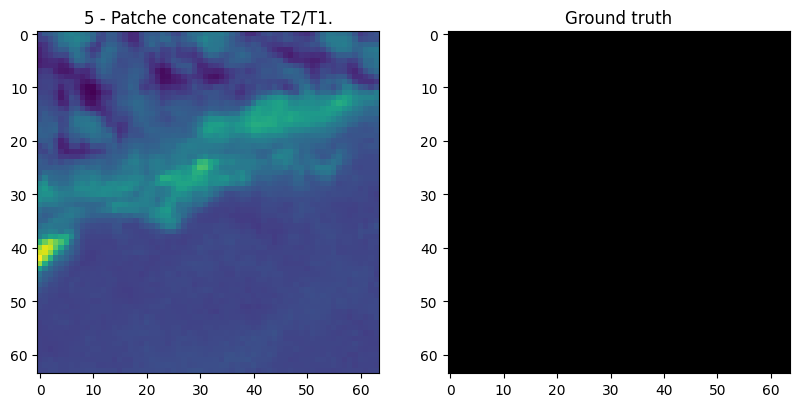

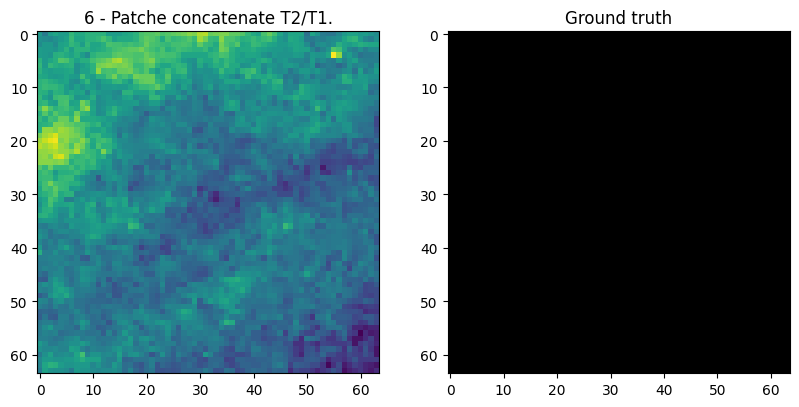

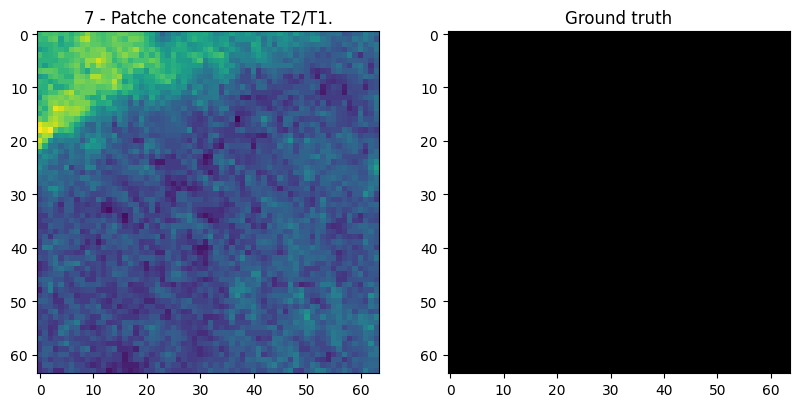

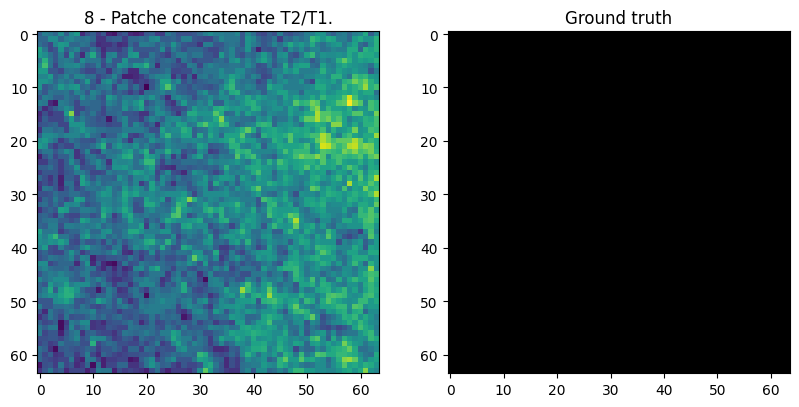

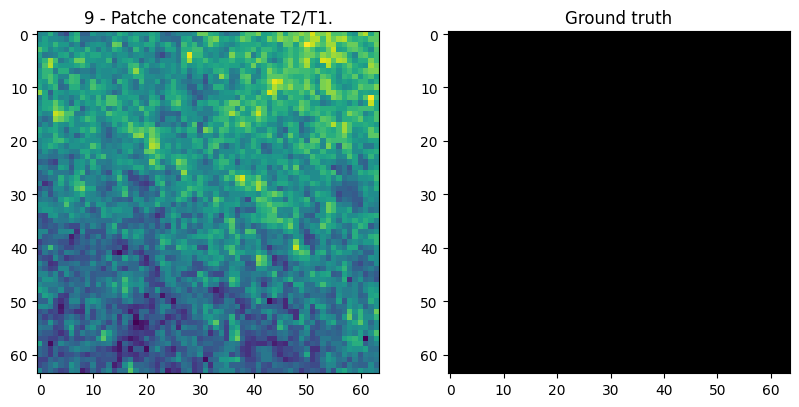

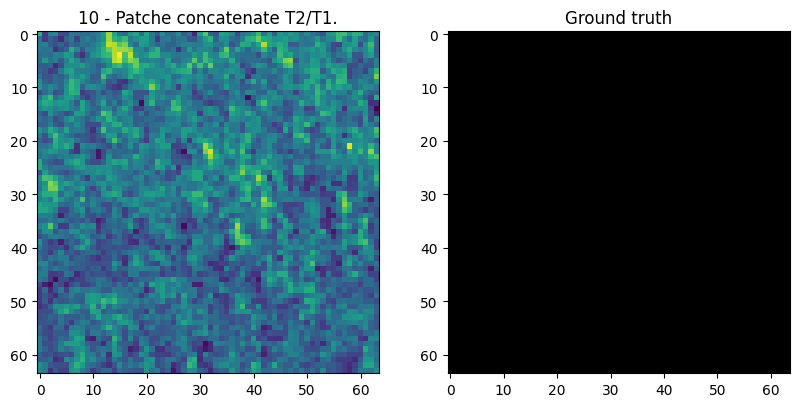

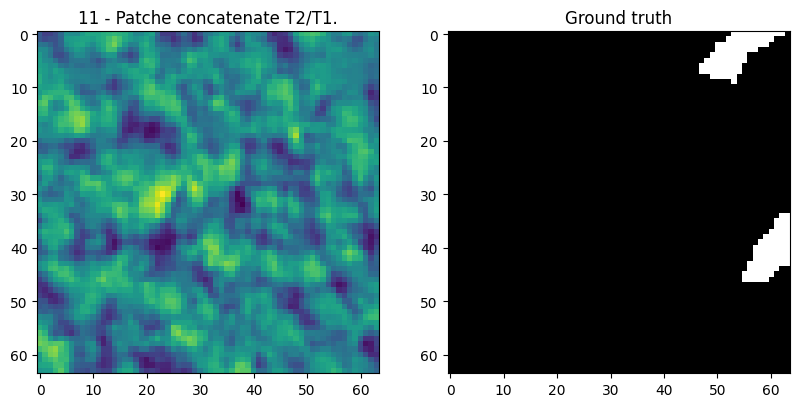

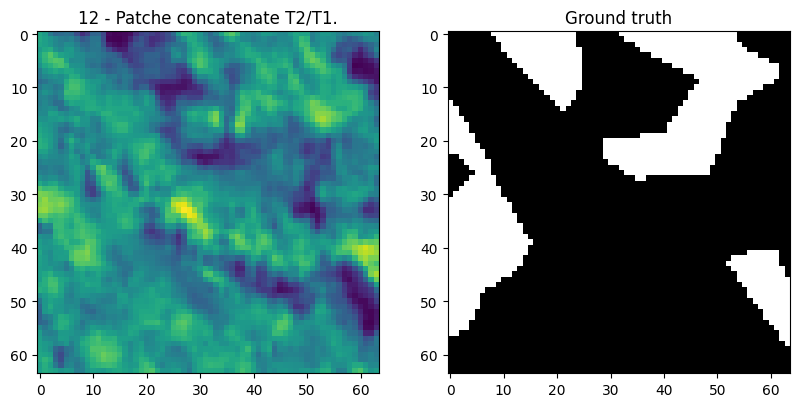

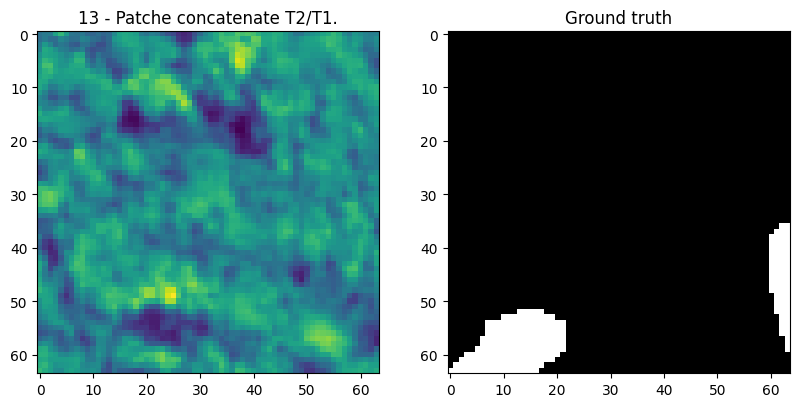

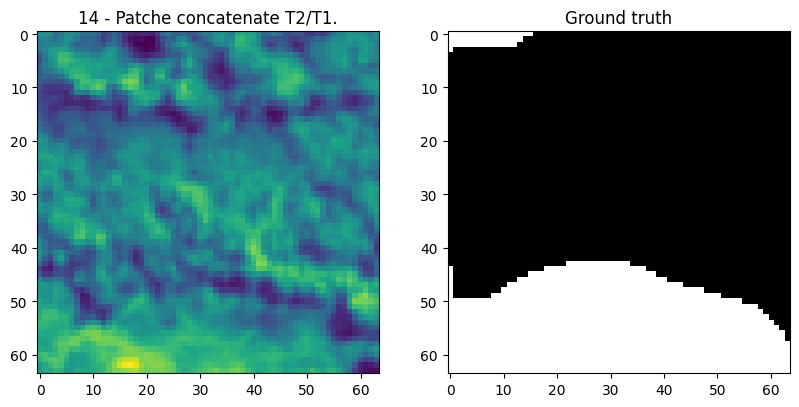

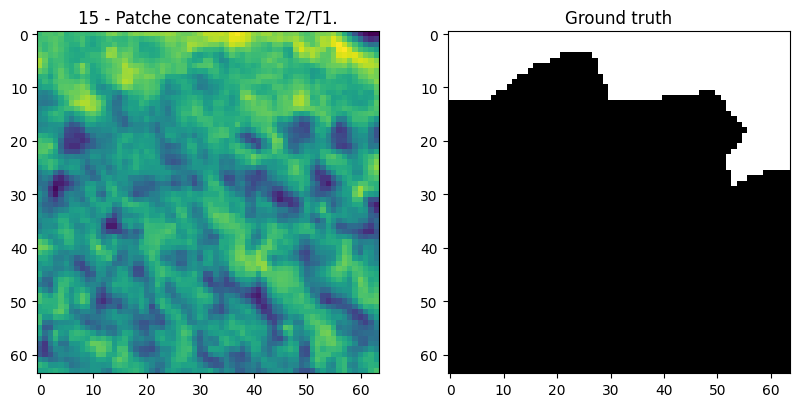

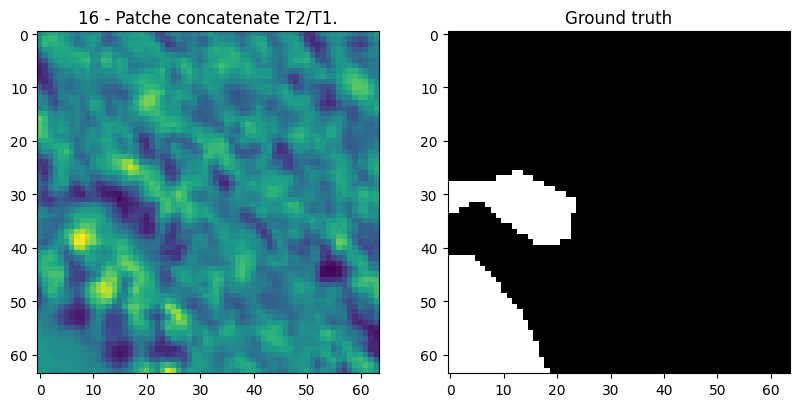

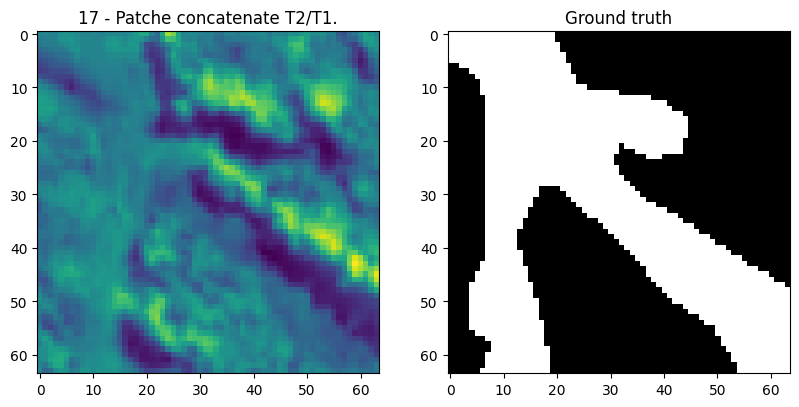

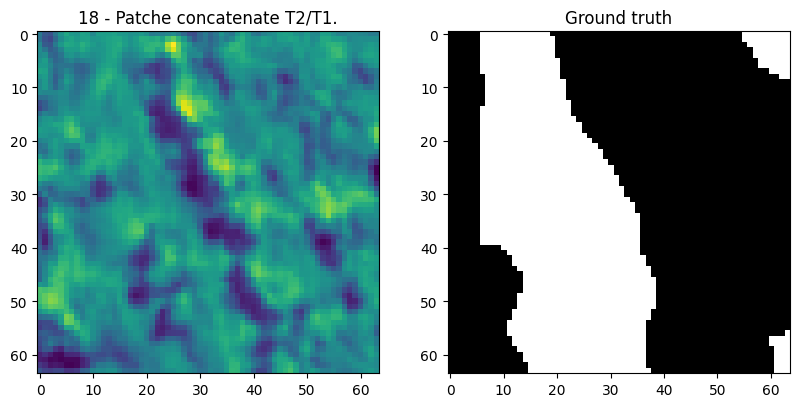

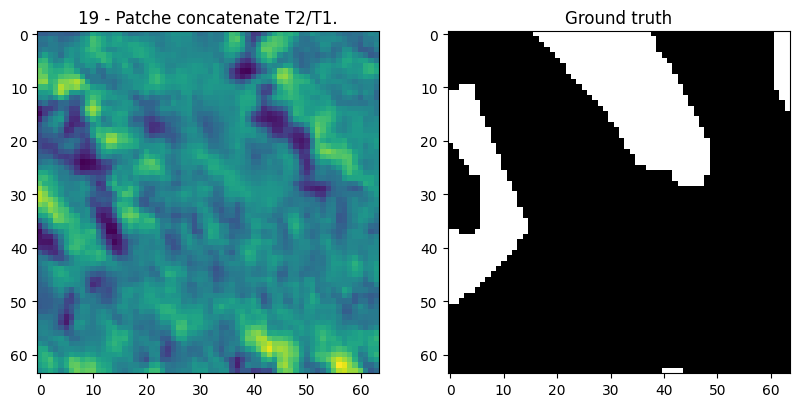

In [40]:
# problema para mostrar classes com img do cod. shape2raster.
for index in range(20): #len(patche_classe_combined)

  # Visualiza: Raster do subconjunto de treinamento
  plt.figure(figsize=(15, 10))
  plt.subplot(131)
  plt.imshow(patche_cena__[index])
  plt.title(f'{index} - Patche concatenate T2/T1.')

  # Visualiza: Label
  plt.subplot(132)
  plt.imshow(patche_classe[index], cmap='gray')
  plt.title('Ground truth')
  plt.show()

# yt.shap

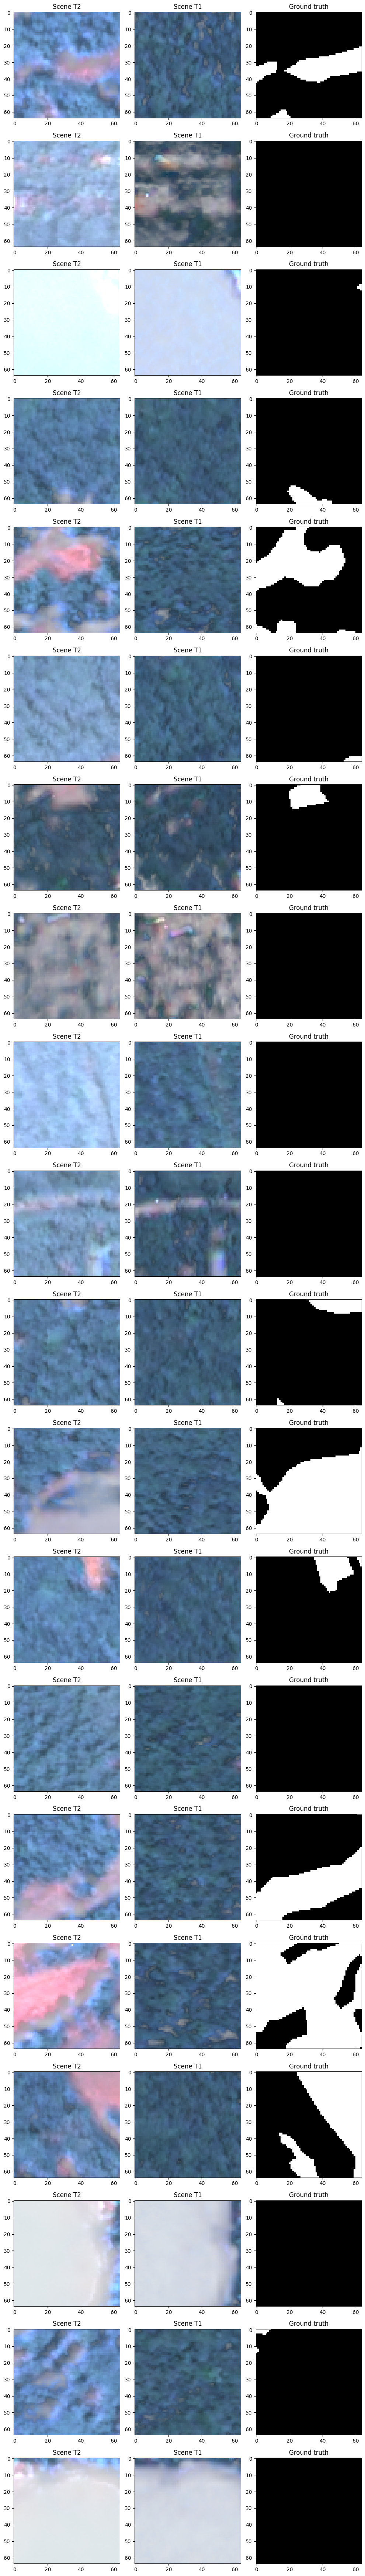

In [41]:
# visualização das imagens de teste
def visualize_images(num_rows, random_indices):
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 70))

    for i in range(num_rows):
        # Stack BGR NIR to RGB NIR - 8 channels -> 4 channels
        image_rgb_t1 = np.stack([patche_cena_combined[random_indices[i], :, :, 6], patche_cena_combined[random_indices[i], :, :, 5],
                                         patche_cena_combined[random_indices[i], :, :, 4], patche_cena_combined[random_indices[i], :, :, 7]], axis=2)
        image_rgb_t2 = np.stack([patche_cena_combined[random_indices[i], :, :, 2], patche_cena_combined[random_indices[i], :, :, 1],
                                        patche_cena_combined[random_indices[i], :, :, 0], patche_cena_combined[random_indices[i], :, :, 3]], axis=2)

        image_rgb_t1 = image_rgb_t1 / image_rgb_t1.max()
        image_rgb_t2 = image_rgb_t2 / image_rgb_t2.max()

        ground_truth = patche_classe_combined[random_indices[i]]
        # predict = y_pred_argmax[random_indices[i]]


        # Cena T2
        axes[i, 0].imshow(image_rgb_t2*2)
        axes[i, 0].set_title('Scene T2')

        # Cena T1
        axes[i, 1].imshow(image_rgb_t1*2)
        axes[i, 1].set_title('Scene T1')

        # Ground truth
        axes[i, 2].imshow(ground_truth, cmap='gray')
        axes[i, 2].set_title('Ground truth')

    plt.tight_layout()
    plt.show()

# Escolha aleatoriamente algumas imagens para visualizar
num_samples = 20
random_indices = np.random.randint(0, patche_cena_combined.shape[0], num_samples)


# Visualizar as cenas e as classes lado a lado
visualize_images(num_samples, random_indices)

## 4: Tensorflow Keras
## Introdução
### Modelo de Segmentação Semântica CNN utilizando Keras, para classificação pixel a pixel de patches de imagens bitempotais de deslizamentos de terra. A ideia desse projeto foi utilizar a  arquitetura de Segmentação Semântica U-net, usada no Hackathon WORKCAP 2022 para classes do Cerrado, organizado pelo Instituto Nacional de Pesquisa Espacial (INPE) [1], aplicando a resolução para o domínio deslizamento de terra.
<hr style="border:1px solid #7D26CD">

## 5: Construção da rede neural

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Recall, Precision

In [43]:
# Função IoU para 8 canais
def iou_8_channels(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))

    return intersection / (union + tf.keras.backend.epsilon())

tf.keras.utils.get_custom_objects().update({"iou_8_channels": iou_8_channels})

In [44]:
epochs = 100
batch_size = 32
lr = 1e-4

### 5.1: Modelo U-Net

In [45]:
def unet(input_size ,num_classes):
    inputs = keras.layers.Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.20)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.22)(conv4)

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([drop3,up5], axis = 3)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(num_classes, 1, activation = 'softmax',padding='same')(conv7)


    model = Model(inputs = inputs, outputs = conv7)

    return model

#### 5.1.1: Função de perda de entropia cruzada.
##### É usada quando houver duas ou mais classes de rótulos. Esperando que os rótulos sejam fornecidos como ```números inteiros```. Se você quiser fornecer rótulos usando representação one-hot (propenso a criar muitos preditores), use CategoricalCrossentropy loss. Deve haver \# classes valores de ponto flutuante por recurso para y_pred e um único valor de ponto flutuante por recurso para y_true [4].

In [46]:
model = unet(input_size= (64,64,8), num_classes=2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr), metrics = ['accuracy', iou_8_channels])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 8)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           4672      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## 6: Treinamento com validação de 20%

In [47]:
# len(np.unique(train_label))
np.unique(patche_classe)  # salvando aumento de dados com dtype=uint8

array([0., 1.], dtype=float32)

In [48]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)
path_modelo = 'modelos'
criar_diretorio(path_modelo)

In [49]:
callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.h5', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=10)]

In [50]:
start = time.time()
history = model.fit(patche_cena_combined,patche_classe_combined,batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)
print('Completed in ', time.time() - start, 's')

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8649 - iou_8_channels: 0.0045
Epoch 1: val_loss improved from inf to 0.28213, saving model to modelos/modelo_drive_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 26s 171ms/step - loss: 0.3583 - accuracy: 0.8649 - iou_8_channels: 0.0045 - val_loss: 0.2821 - val_accuracy: 0.8590 - val_iou_8_channels: 0.0000e+00
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.8815 - iou_8_channels: 0.0000e+00
Epoch 2: val_loss improved from 0.28213 to 0.21546, saving model to modelos/modelo_drive_02.h5
35/35 [==============================] - 5s 140ms/step - loss: 0.2095 - accuracy: 0.8815 - iou_8_channels: 0.0000e+00 - val_loss: 0.2155 - val_accuracy: 0.8590 - val_iou_8_channels: 0.0000e+00
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.8829 - iou_8_channels: 0.0162    
Epoch 3: val_loss improved from 0.21546 to 0.18795, saving model to modelos/modelo_drive_03.h5
35/35 [==============================] - 5s 137ms/step - loss: 0.1764 - accuracy: 0.8829 - iou_8_channels: 0.0162 - val_loss: 0.1880 - val_accuracy: 0.9365 - val_iou_8_channels: 0

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'iou_8_channels', 'val_loss', 'val_accuracy', 'val_iou_8_channels'])

In [52]:
# Delete variáveis
del patche_cena, patche_classe, patche_cena_, patche_cena_augmented, patche_classe_augmented, patche_cena_combined, patche_classe_combined

In [53]:
def grafico_acc(history):
    fig = plt.gcf()
    fig.set_size_inches(8,4)
    plt.subplot(1,1,1)
    plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
    plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

def grafico_loss(history):
    fig = plt.gcf()
    fig.set_size_inches(8,4)
    plt.subplot(1,1,1)
    plt.plot(history.history['loss'], 'red', label='Loss treinamento')
    plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
    plt.legend()
    plt.title('Loss')
    plt.show()

def grafico_iou_8_channels(history):
    fig = plt.gcf()
    fig.set_size_inches(8,4)
    plt.subplot(1,1,1)
    plt.plot(history.history['iou_8_channels'], 'red', label='IoU treinamento')
    plt.plot(history.history['val_iou_8_channels'], 'blue', label='IoU validação')
    plt.legend()
    plt.title('IoU')
    plt.show()

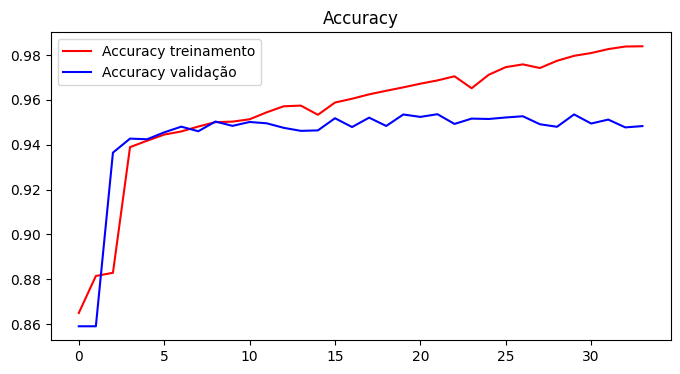

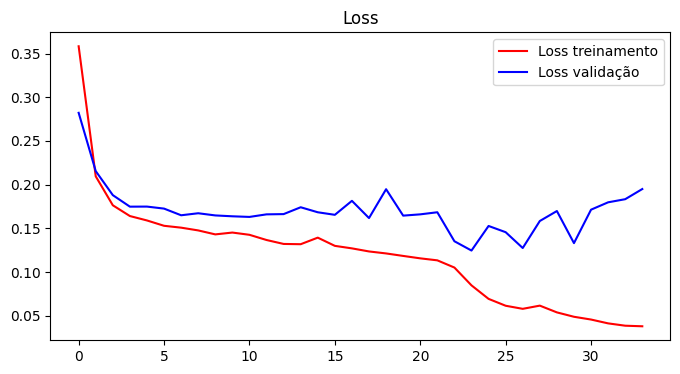

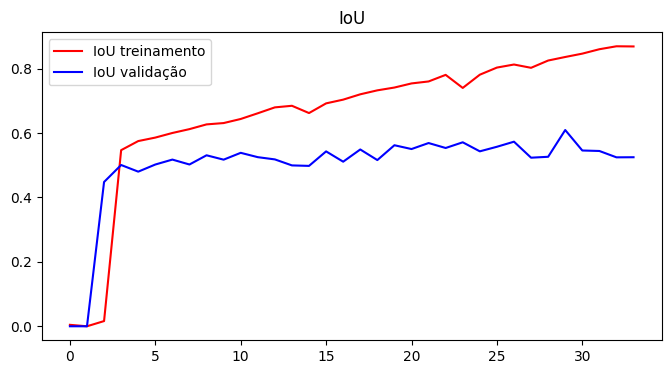

In [54]:
grafico_acc(history)
grafico_loss(history)
grafico_iou_8_channels(history)

## 7: Teste - separado 20% para visualizar inferência, porém será treinado com todo dataset para inferência em domínio de Petrópolis (dataset desbalanceado).

In [55]:
# Predicão
y_pred = model.predict(patche_cena_test)

6/6 [==============================] - 1s 233ms/step


In [56]:
# Retorna os valores máximos dos índices no eixo 3
y_pred_argmax = np.argmax(y_pred, axis=3)

In [57]:
# Altera o tipo de dado para int16
y_pred_argmax = y_pred_argmax.astype('int16')

In [58]:
y_pred_argmax.shape

(188, 64, 64)

In [59]:
# test_patche_cena_ = test_patche_cena[:,:,:,0]
# test_patche_cena_.shape

In [60]:
# # Vizualização dos patches e predito
# for index in range(len(test_patche_cena_)):
#     # Faz Stack do y_pred_argmax
#     yp = np.dstack((y_pred_argmax[index],y_pred_argmax[index],y_pred_argmax[index]))
#     ym = np.dstack((test_patche_classe[index],test_patche_classe[index],test_patche_classe[index]))

#     # Visualiza subconjunto de teste
#     plt.figure(figsize=(9, 6))
#     plt.subplot(131)
#     plt.imshow(test_patche_cena_[index])
#     plt.title(f'{index} - Test Patch T2/T1')

#     # Visualiza subconjunto de teste

#     plt.subplot(132)
#     # plt.imshow(test_patche_classe[index])
#     m = image.array_to_img(ym)
#     m = PIL.ImageOps.autocontrast(m)
#     plt.imshow(m)
#     plt.title('Ground truth T2/T1')

#     # Visualiza: subconjunto classificado
#     plt.subplot(133)
#     m1 = image.array_to_img(yp)
#     m1 = PIL.ImageOps.autocontrast(m1)
#     plt.imshow(m1)
#     plt.title('Predict');

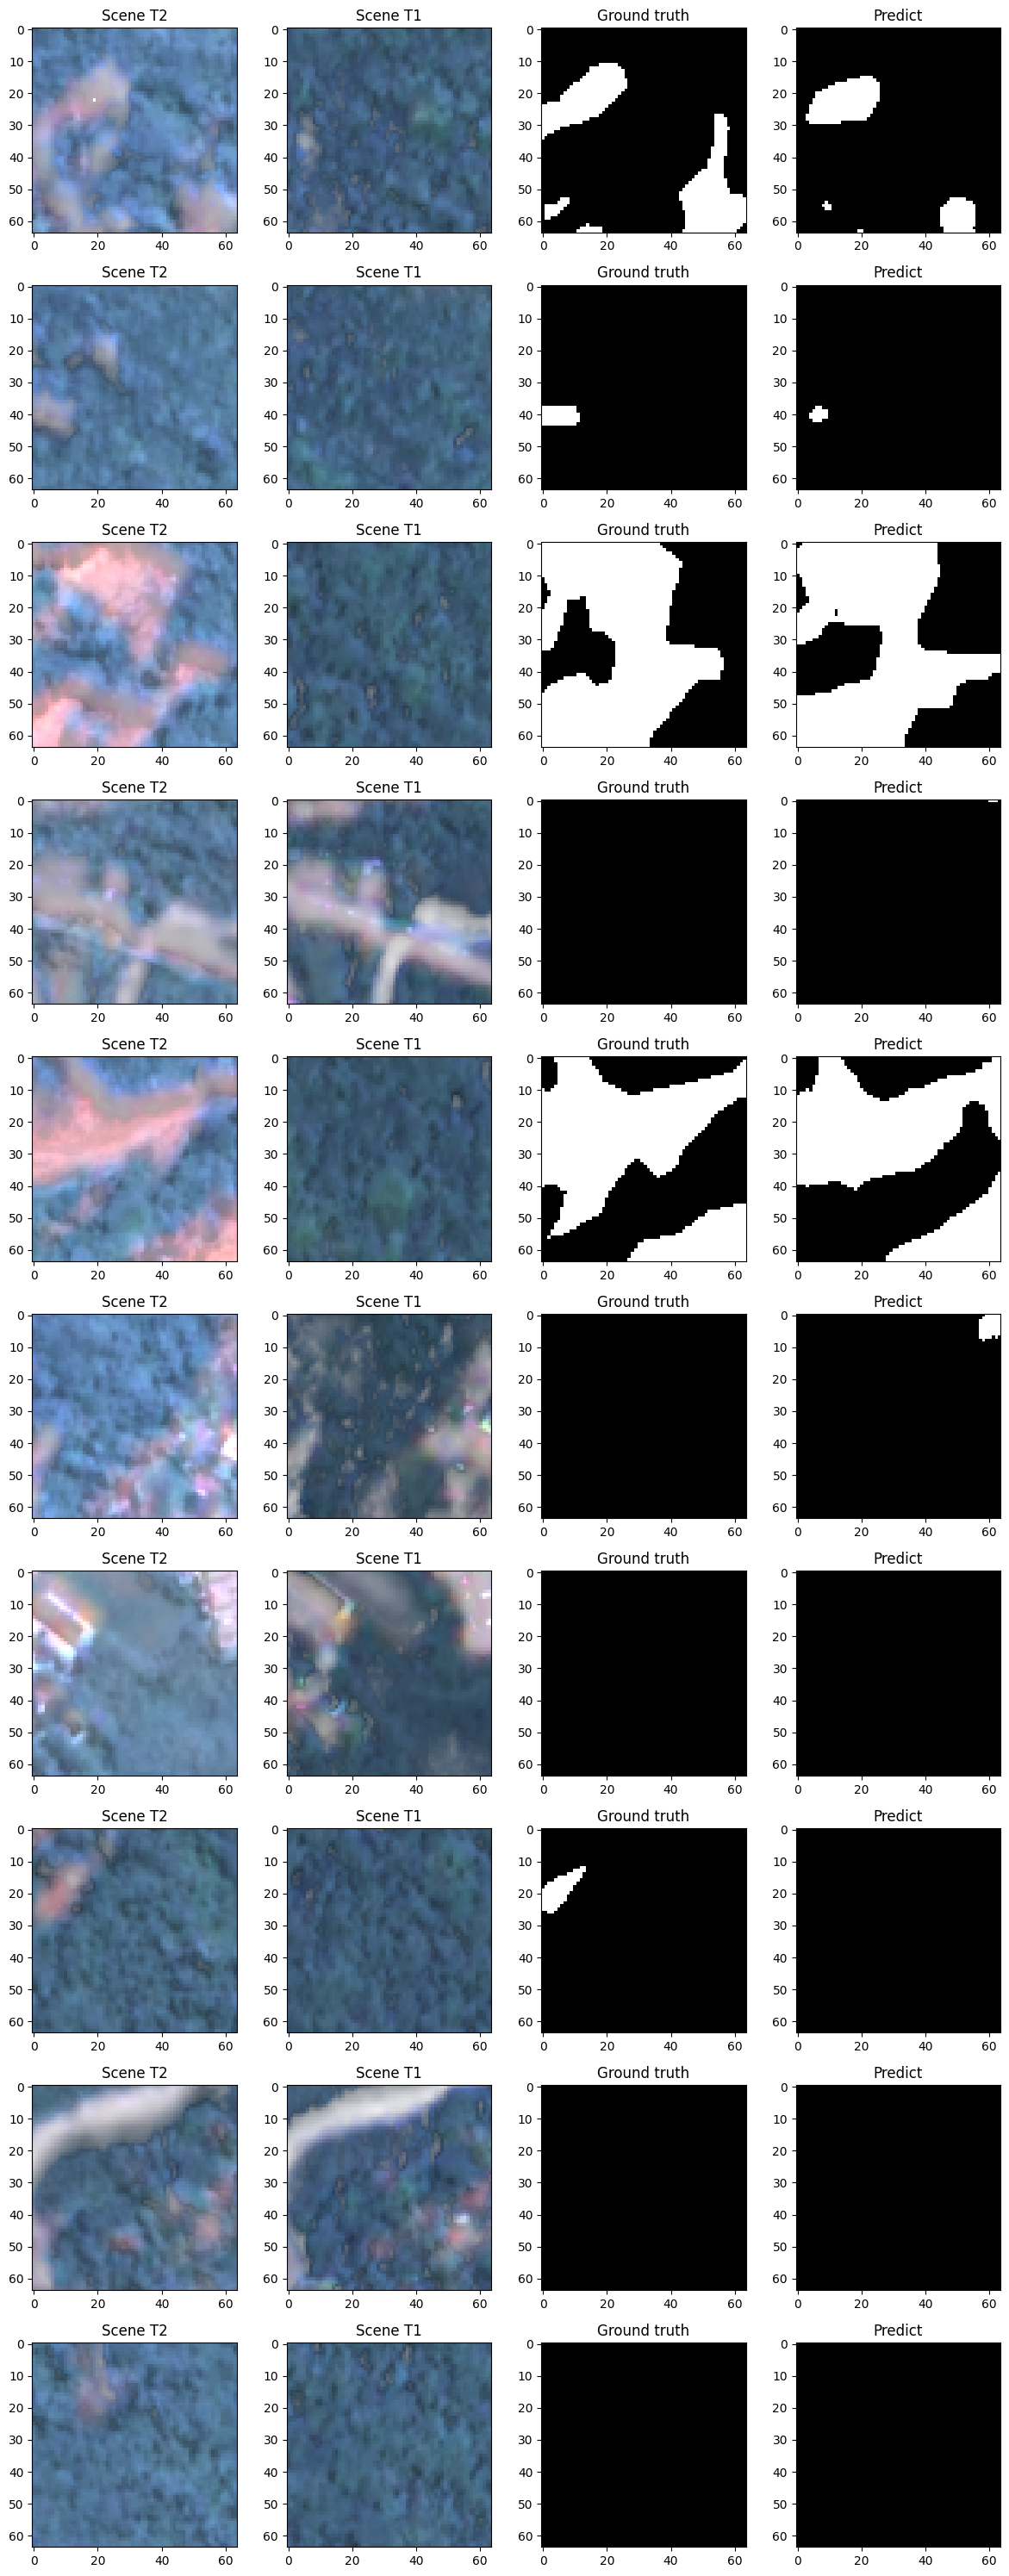

In [85]:
# visualização das imagens de teste
def visualize_images(num_rows, random_indices):
    fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))

    for i in range(num_rows):
        # Stack BGR NIR to RGB NIR - 8 channels -> 4 channels
        image_rgb_t1 = np.stack([patche_cena_test[random_indices[i], :, :, 6], patche_cena_test[random_indices[i], :, :, 5],
                                         patche_cena_test[random_indices[i], :, :, 4], patche_cena_test[random_indices[i], :, :, 7]], axis=2)
        image_rgb_t2 = np.stack([patche_cena_test[random_indices[i], :, :, 2], patche_cena_test[random_indices[i], :, :, 1],
                                        patche_cena_test[random_indices[i], :, :, 0], patche_cena_test[random_indices[i], :, :, 3]], axis=2)

        image_rgb_t1 = image_rgb_t1 / image_rgb_t1.max()
        image_rgb_t2 = image_rgb_t2 / image_rgb_t2.max()

        # image_rgb_t1 = patche_cena_test[random_indices[i], :, :, 4:]
        # image_rgb_t2 = patche_cena_test[random_indices[i], :, :, :4]

        ground_truth = patche_classe_test[random_indices[i]]
        predict = y_pred_argmax[random_indices[i]]

        # Cena T2
        axes[i, 0].imshow(image_rgb_t2*2)
        axes[i, 0].set_title('Scene T2')

        # Cena T1
        axes[i, 1].imshow(image_rgb_t1*2)
        axes[i, 1].set_title('Scene T1')

        # Ground truth
        axes[i, 2].imshow(ground_truth, cmap='gray')
        axes[i, 2].set_title('Ground truth')

        # Predict
        axes[i, 3].imshow(predict, cmap='gray')
        axes[i, 3].set_title('Predict')

    plt.tight_layout()
    plt.show()

# Escolha aleatoriamente algumas imagens para visualizar
num_samples = 10
random_indices = np.random.randint(0, patche_cena_test.shape[0], num_samples)

# Visualizar as cenas e as classes lado a lado
visualize_images(num_samples, random_indices)

In [62]:
del cbers_, org_path_pacth1, org_path_label1, patche, label

## -> 8: Salvar e carregar o modelo




In [63]:
# from google.colab import drive
# drive.mount('/content/drive')

In [64]:
# copiando e salvando o ultimo modelo no drive - para novos treinamentos
# !cp /content/modelos/modelo_drive_08.h5 /content/drive/MyDrive/modelos/modelo_ssebastiao_aug_treina_8e.h5  # aug correto 01/08/2023

In [65]:
# copiando modelo para colab
# !cp /content/drive/MyDrive/Models_Unet/modelo_ssebastiao_treina_25e.h5   modelo_ssebastiao_treina_25e.h5

In [66]:
# from tensorflow.keras.utils import CustomObjectScope
# from tensorflow.keras.models import load_model

In [67]:
# model_ = load_model('modelo_ssebastiao_treina_25e.h5')

In [68]:
# model_.load_weights('modelo_ssebastiao_treina_25e.h5')

## 9: F1-Score e Acurácia do Teste

In [69]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9530325080852566
Accuracy:  0.9563286963929521


## 10: Métrica IoU [2]

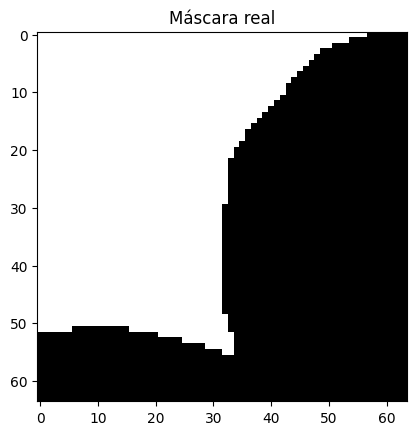

In [70]:
id_img_teste = 164
img_teste = patche_cena_test[id_img_teste]
ground_truth = patche_classe_test[id_img_teste]
plt.imshow(np.squeeze(ground_truth), cmap='gray')
plt.title('Máscara real');

In [71]:
from tensorflow.keras.metrics import MeanIoU
iou_resultado = MeanIoU(num_classes = 2)

In [72]:
img_teste.shape

(64, 64, 8)

In [73]:
# test_img_input = np.expand_dims(img_teste, 0)
# test_img_input.shape
img_test = img_teste.reshape(1, 64, 64, 8)

In [74]:
# img_test = img_test / 255.0  # Normalização no intervalo [0, 1]

In [75]:
predictions = model.predict(img_test)

1/1 [==============================] - 1s 528ms/step


In [76]:
predictions = tf.argmax(predictions, axis=-1)

In [77]:
ground_truth = ground_truth.reshape(1, 64, 64, 1)

In [78]:
ground_truth = tf.cast(ground_truth, tf.int64)

In [79]:
iou_resultado.update_state(ground_truth, predictions)
iou = iou_resultado.result()

In [80]:
ground_truth.shape, predictions.shape

(TensorShape([1, 64, 64, 1]), TensorShape([1, 64, 64]))

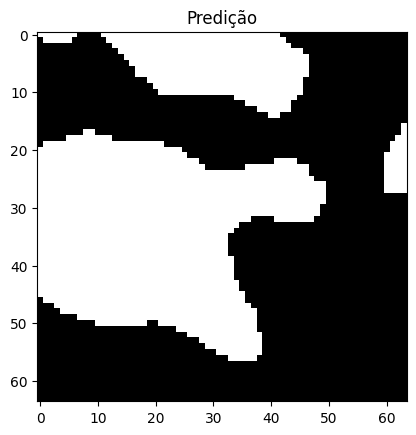

In [81]:
plt.imshow(predictions[0], cmap='gray')
plt.title('Predição')
plt.show()

In [82]:
iou_resultado = MeanIoU(num_classes=2)
iou_resultado.update_state(ground_truth, predictions)
iou = iou_resultado.result().numpy()
print('IoU para a imagem:', iou)

IoU para a imagem: 0.64422804


In [83]:
# import pandas as pd

# valores_IoU = []
# iou_resultado = MeanIoU(num_classes=2)

# for idx in range(patche_cena_test.shape[0]):
#     img = patche_cena_test[idx]
#     ground_truth = patche_classe_test[idx]

#     img_test = img.reshape(1, 64, 64, 8)
#     # img_test = img_test / 255.0  # Normalização no intervalo [0, 1]

#     predictions = model.predict(img_test)
#     predictions = tf.argmax(predictions, axis=-1)

#     ground_truth = ground_truth.reshape(1, 64, 64, 1)
#     ground_truth = tf.cast(ground_truth, tf.int64)

#     iou_resultado.update_state(ground_truth, predictions)  # atualização
#     iou = iou_resultado.result().numpy()
#     valores_IoU.append(iou)

#     iou_resultado.reset_states()

# df = pd.DataFrame(valores_IoU, columns=["IoU"])
# df = df[df.IoU != 1.0]

# media_IoU = df.mean().values
# print("Média do IoU para " + str(len(valores_IoU)) + " imagens: ", media_IoU)

In [84]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = img_teste.reshape(1, 64, 64, 8)
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

# Substitua 'patche_cena_test' e 'patche_classe_test' pelos seus dados reais
calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 [==============================] - 0s 19ms/step
IoU para a imagem 0: 0.4840087890625
1/1 [==============================] - 0s 19ms/step
IoU para a imagem 1: 1.0
1/1 [==============================] - 0s 17ms/step
IoU para a imagem 2: 1.0
1/1 [==============================] - 0s 20ms/step
IoU para a imagem 3: 1.0
1/1 [==============================] - 0s 23ms/step
IoU para a imagem 4: 1.0
1/1 [==============================] - 0s 18ms/step
IoU para a imagem 5: 1.0
1/1 [==============================] - 0s 17ms/step
IoU para a imagem 6: 1.0
1/1 [==============================] - 0s 17ms/step
IoU para a imagem 7: 1.0
1/1 [==============================] - 0s 20ms/step
IoU para a imagem 8: 1.0
1/1 [==============================] - 0s 20ms/step
IoU para a imagem 9: 1.0
1/1 [==============================] - 0s 24ms/step
IoU para a imagem 10: 1.0
1/1 [==============================] - 0s 18ms/step
IoU para a imagem 11: 0.6286987066268921
1/1 [==============================] - 0s 18ms/

## 11: Conclusão
### A avaliação dos resultados foi melhor compreendida com a convergência do modelo de treinamento e a vizualização das segmentações dos rótudos feitas pelo algoritmo, juntamente com o método IoU (*Intersection Over Union*), foi possível visualizar a melhora das predições com os rótulos verdadeiros do conjunto de teste, portanto generalizados. Em trabalhos futuros deverá ser realizado comparações com arquiteturas de modelos como a DeepLabV3. Além disso, o processamento das imagens bitemporais deverão ser mais precisas, com registro (sem deslocamento) e um melhor segmento das máscaras de deslizamentos, considerando os mapas do site *Charter* [6] como verdade de campo, e uma melhor segmentação vetorizada pela biblioteca RSGISLib [7].

## Referências

> Indented block


  - [1] [Notebook WorkCAP Hackathon 2022](https://www.kaggle.com/code/grupohackaton2022/hackathon-notebook)
  - [2] [Python for Geosciences: Raster Merging, Clipping and Reprojection with Rasterio](https://medium.com/analytics-vidhya/python-for-geosciences-raster-merging-clipping-and-reprojection-with-rasterio-9f05f012b88a)
  - [3] [Patch Generator](https://github.com/vdlucas-queiroz/patch_generator/)
  - [4] [TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
  - [5] [Segmentação de Imagens com Python de A a Z](https://iaexpert.academy/cursos-online-assinatura/segmentacao-imagens-python-a-z/)
  - [6] [The International Charter Space and Major Disasters](https://disasterscharter.org/web/guest/activations/-/article/landslide-in-brazil-activation-758-)
  - [7] [RSGISLib Image Segmentation Module](http://rsgislib.org/rsgislib_segmentation.html)